# Data Exploration

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob

In [3]:
DATA_DIR = "../data"
RAW_DATA_DIR = os.path.join(DATA_DIR, "raw")

## Labels

In [5]:
csv_filepath = "data/raw/leaf_grouping/leaf_maps/Apple_Frogeye Spot.csv"
os.path.basename(csv_filepath)

'Apple_Frogeye Spot.csv'

## Leaf Mappings

There are multiple images per leaf, taken from different angles. The CSVs map the image filenames to a leaf.

In [4]:
import pandas as pd

In [5]:
LEAF_MAPS_DIR = os.path.join(RAW_DATA_DIR, "leaf_grouping", "leaf_maps")
FILTERED_LEAF_MAPS_DIR = os.path.join(RAW_DATA_DIR, "leaf_grouping", "filtered_leafmaps")

In [6]:
def csv_summary(df):
    print(f"num_rows: {df.shape[0]}, num_columns: {df.shape[1]}")
    print(f"columns: {list(df.columns)}")
    return df.head()
    
def load_csv(base_dir, filename):
    df = pd.read_csv(os.path.join(base_dir, filename), engine="python")
    return df

In [7]:
apple_scab_df = load_csv(LEAF_MAPS_DIR, "Apple_Scab.csv")
csv_summary(apple_scab_df)

num_rows: 630, num_columns: 2
columns: ['File Name', 'Leaf #']


,File Name,Leaf #
0,FREC_Scab 2907.JPG,1.0
1,FREC_Scab 2908.JPG,1.0
2,FREC_Scab 2909.JPG,1.0
3,FREC_Scab 2910.JPG,1.0
4,FREC_Scab 2911.JPG,1.0


In [8]:
strawberry_scorch_df = load_csv(LEAF_MAPS_DIR, "Strawberry_Scorch.csv")
csv_summary(strawberry_scorch_df)

num_rows: 776, num_columns: 2
columns: ['File Name', 'Leaf #']


,File Name,Leaf #
0,RS_L.Scorch 0844.JPG,1.0
1,RS_L.Scorch 0845.JPG,1.0
2,RS_L.Scorch 0846.JPG,1.0
3,RS_L.Scorch 0847.JPG,1.0
4,RS_L.Scorch 0848.JPG,1.0


In [9]:
load_csv(LEAF_MAPS_DIR, "Raspberry_Sheet1.csv")

,File Name,Leaf #
0,Mary_HL 6214.JPG,1.0
1,Mary_HL 6215.JPG,1.0
2,Mary_HL 6216.JPG,1.0
3,Mary_HL 6217.JPG,1.0
4,Mary_HL 6218.JPG,1.0
...,...,...
366,Mary_HL 9351.JPG,37.0
367,Mary_HL 9352.JPG,37.0
368,Mary_HL 9353.JPG,37.0
369,Mary_HL 9354.JPG,37.0


In [10]:
load_csv(FILTERED_LEAF_MAPS_DIR, "Apple___Apple_scab.csv")

,File Name,Leaf #
0,FREC_Scab 2907.JPG,1.0
1,FREC_Scab 2908.JPG,1.0
2,FREC_Scab 2909.JPG,1.0
3,FREC_Scab 2910.JPG,1.0
4,FREC_Scab 2911.JPG,1.0
...,...,...
625,FREC_Scab 3533.JPG,108.0
626,FREC_Scab 3534.JPG,108.0
627,FREC_Scab 3535.JPG,108.0
628,FREC_Scab 3536.JPG,108.0


## Images

In [8]:
from matplotlib.pyplot import imshow
import numpy as np
#from PIL import Image
from IPython.core.display import display

%matplotlib inline

### PIL

https://pillow.readthedocs.io/en/stable/handbook/tutorial.html#processing-individual-bands


In [62]:
RAW_IMAGES_DIR = os.path.join(RAW_DATA_DIR, "raw")
COLOR_IMAGES_DIR = os.path.join(RAW_IMAGES_DIR, "color")

In [79]:
apple_scab_filenames = glob.glob(os.path.join(COLOR_IMAGES_DIR, "Apple___Apple_scab", "*.JPG"))

In [103]:
im = Image.open(apple_scab_filenames[0])

In [104]:
print(im.format, im.size, im.mode)

JPEG (256, 256) RGB


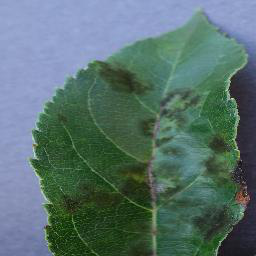

In [105]:
im

In [106]:
# split the image into individual bands
R, G, B = 0, 1, 2
source = im.split()

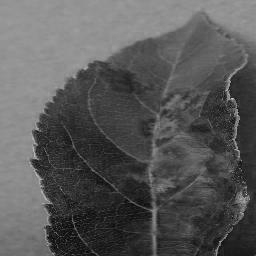

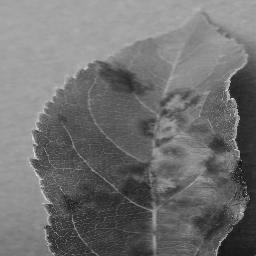

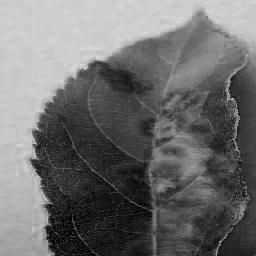

In [107]:
for i in range(3):
    display(source[i])

In [132]:
# select regions where green is less than 100
mask = source[G].point(lambda i: i < 100 and 255)

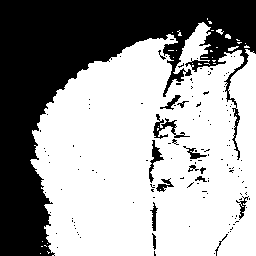

In [133]:
display(mask)

In [115]:
# process the red band
out = source[G].point(lambda i: i * 0.7)

In [116]:
# paste the processed band back, but only where red was < 100
source[G].paste(out, None, mask)

In [120]:
help(source[G].paste)

Help on method paste in module PIL.Image:

paste(im, box=None, mask=None) method of PIL.Image.Image instance
    Pastes another image into this image. The box argument is either
    a 2-tuple giving the upper left corner, a 4-tuple defining the
    left, upper, right, and lower pixel coordinate, or None (same as
    (0, 0)). See :ref:`coordinate-system`. If a 4-tuple is given, the size
    of the pasted image must match the size of the region.
    
    If the modes don't match, the pasted image is converted to the mode of
    this image (see the :py:meth:`~PIL.Image.Image.convert` method for
    details).
    
    Instead of an image, the source can be a integer or tuple
    containing pixel values.  The method then fills the region
    with the given color.  When creating RGB images, you can
    also use color strings as supported by the ImageColor module.
    
    If a mask is given, this method updates only the regions
    indicated by the mask.  You can use either "1", "L" or "RGBA

In [117]:
# build a new multiband image
im2 = Image.merge(im.mode, source)

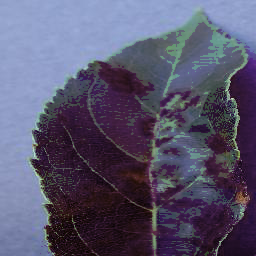

In [118]:
display(im2)

# Feature Extraction

## Steps

1. Isolate the object (leaf) in the photo by masking pixels/removing the background.
2. Dark spots

In [160]:
import random
from PIL import Image

BANDS = ["R", "G", "B"]


def load_image(filename, separate_bands=True):
    print(filename)
    im = Image.open(filename)
    print(im.format, im.size, im.mode)
    if separate_bands:
        print("Separate bands")
        return im.split()
    return im

def display_bands(img):
    display(im)
    source = im.split()
    for i in range(len(BANDS)):
        print(f"BAND {BANDS[i]}")
        display(source[i])

def random_filename(filenames):
    idx = random.randint(0, len(filenames))
    return filenames[idx]

## References

* https://spj.sciencemag.org/plantphenomics/2019/9237136/
* https://www.analyticsvidhya.com/blog/2019/04/introduction-image-segmentation-techniques-python/
* https://towardsdatascience.com/introduction-to-image-segmentation-with-k-means-clustering-83fd0a9e2fc3
* https://www.geeksforgeeks.org/ml-training-image-classifier-using-tensorflow-object-detection-api/
* https://towardsdatascience.com/object-detection-via-color-based-image-segmentation-using-python-e9b7c72f0e11

In [140]:
filename = random_filename(apple_scab_filenames)
im = load_image(filename)

../data/raw/raw/color/Apple___Apple_scab/3f65aa69-06c9-423f-ac7a-e2ab6edf63ca___FREC_Scab 3360.JPG
JPEG (256, 256) RGB
Separate bands


Opening ../data/raw/raw/color/Apple___Apple_scab/3f65aa69-06c9-423f-ac7a-e2ab6edf63ca___FREC_Scab 3360.JPG


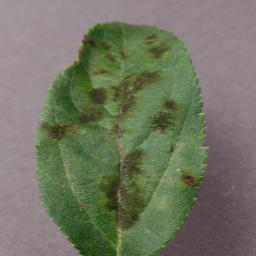

BAND R


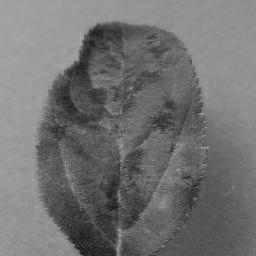

BAND G


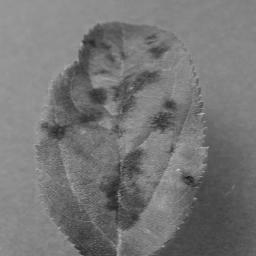

BAND B


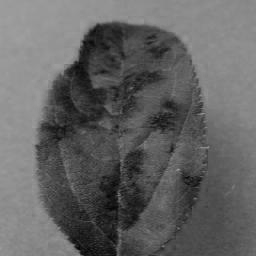

In [141]:
display_bands(filename)

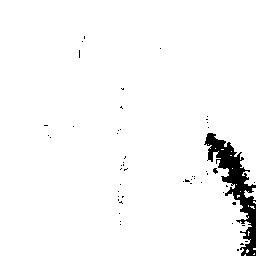

In [179]:
im[R].point(lambda i: i < 100 and 255)

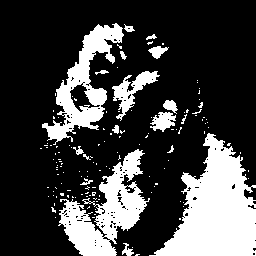

In [180]:
# mask = im[G].point(lambda i: i > 100 and 255)
im[G].point(lambda i: i < 100 and 255)

In [181]:
# create mask from band with most continuous coverage
mask = im[B].point(lambda i: i < 100 and 255)

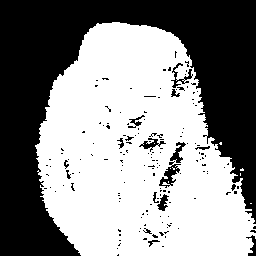

In [ ]:
source[G].paste(out, None, mask)

In [200]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

(256, 256, 3)


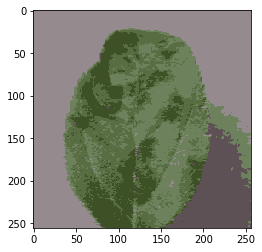

In [214]:
# https://www.analyticsvidhya.com/blog/2019/04/introduction-image-segmentation-techniques-python/
# https://towardsdatascience.com/introduction-to-image-segmentation-with-k-means-clustering-83fd0a9e2fc3
filename = "../data/raw/raw/color/Apple___Apple_scab/3f65aa69-06c9-423f-ac7a-e2ab6edf63ca___FREC_Scab 3360.JPG"
pic = plt.imread(filename)/255  # dividing by 255 to bring the pixel values between 0 and 1
print(pic.shape)
plt.imshow(pic)
pic_n = pic.reshape(pic.shape[0]*pic.shape[1], pic.shape[2])
pic_n.shape
kmeans = KMeans(n_clusters=5, random_state=0).fit(pic_n)
pic2show = kmeans.cluster_centers_[kmeans.labels_]
cluster_pic = pic2show.reshape(pic.shape[0], pic.shape[1], pic.shape[2])
plt.imshow(cluster_pic)

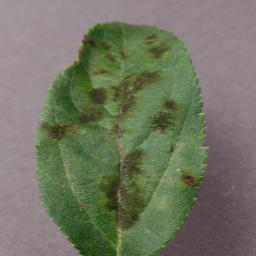

In [205]:
Image.open(filename)

In [223]:
filename = "../data/raw/raw/color/Apple___Cedar_apple_rust/290ad123-7702-4219-9773-17e07f22438c___FREC_C.Rust 4444.JPG"

(256, 256, 3)


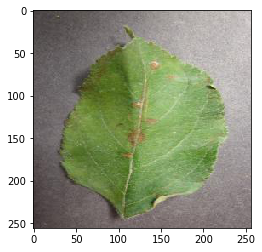

In [224]:
pic = plt.imread(filename)/255  # dividing by 255 to bring the pixel values between 0 and 1
print(pic.shape)
plt.imshow(pic)


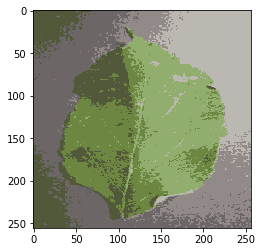

In [227]:
pic_n = pic.reshape(pic.shape[0]*pic.shape[1], pic.shape[2])
pic_n.shape
kmeans = KMeans(n_clusters=6, random_state=0).fit(pic_n)
pic2show = kmeans.cluster_centers_[kmeans.labels_]
cluster_pic = pic2show.reshape(pic.shape[0], pic.shape[1], pic.shape[2])
plt.imshow(cluster_pic)

In [230]:
errors =[]
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i).fit(pic_n)
    kmeans.fit(pic_n)
    errors.append(kmeans.inertia_)

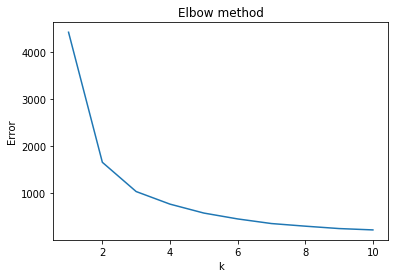

In [231]:
import matplotlib.pyplot as plt
plt.plot(range(1, 11), errors)
plt.title('Elbow method')
plt.xlabel('k')
plt.ylabel('Error')
plt.show()

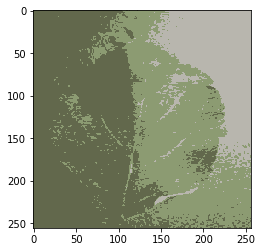

In [232]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(pic_n)
pic2show = kmeans.cluster_centers_[kmeans.labels_]
cluster_pic = pic2show.reshape(pic.shape[0], pic.shape[1], pic.shape[2])
plt.imshow(cluster_pic)

In [14]:
import numpy as np
import cv2 as cv


def viewImage(image):
    cv.namedWindow('Display', cv.WINDOW_NORMAL)
    cv.imshow('Display', image)
    cv.waitKey(0)
    cv.destroyAllWindows()
    
def findGreatesContour(contours):
    largest_area = 0
    largest_contour_index = -1
    i = 0
    total_contours = len(contours)
    while (i < total_contours ):
        area = cv.contourArea(contours[i])
        if(area > largest_area):
            largest_area = area
            largest_contour_index = i
        i+=1
            
    return largest_area, largest_contour_index

In [15]:
## getting green HSV color representation
green = np.uint8([[[0, 255, 0 ]]])
green_hsv = cv.cvtColor(green,cv.COLOR_BGR2HSV)
print( green_hsv)

[[[ 60 255 255]]]


In [23]:
filename = "../data/raw/raw/color/Apple___Apple_scab/3f65aa69-06c9-423f-ac7a-e2ab6edf63ca___FREC_Scab 3360.JPG"
#filename = "../data/raw/raw/color/Apple___healthy/041482f6-6dd6-4ac9-9e59-e973c9bcaf6d___RS_HL 8155.JPG"
filename = "../data/raw/raw/segmented/Apple___healthy/01b32971-5125-4982-98e2-22daa9ae864a___RS_HL 7977_final_masked.jpg"

In [24]:
image = cv.imread(filename)
hsv_img = cv.cvtColor(image, cv.COLOR_BGR2HSV)
viewImage(hsv_img) ## 1
green_low = np.array([45 , 100, 50] )
green_high = np.array([75, 255, 255])
curr_mask = cv.inRange(hsv_img, green_low, green_high)
hsv_img[curr_mask > 0] = ([75,255,200])
viewImage(hsv_img) ## 2
## converting the HSV image to Gray inorder to be able to apply 
## contouring
RGB_again = cv.cvtColor(hsv_img, cv.COLOR_HSV2RGB)
gray = cv.cvtColor(RGB_again, cv.COLOR_RGB2GRAY)
viewImage(gray) ## 3
ret, threshold = cv.threshold(gray, 90, 255, 0)
viewImage(threshold) ## 4
contours, hierarchy =  cv.findContours(threshold,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(image, contours, -1, (0, 0, 255), 3)
viewImage(image) ## 5

In [ ]:
# to get the center of the contour
cnt = contours[13]
M = cv2.moments(cnt)
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])
largest_area, largest_contour_index = findGreatesContour(contours)
print(largest_area)
print(largest_contour_index)
print(len(contours))
print(cX)
print(cY)

In [22]:
# https://docs.opencv.org/3.4/d1/dc5/tutorial_background_subtraction.html
backSub = cv.createBackgroundSubtractorMOG2()
mask = backSub.apply(image)

In [ ]:
viewImage(mask)

# Assemble and Prepare Data

In [4]:
import numpy as np
import os
from src.data import utils
from src.data.image_processing import preprocess_image

/mnt/encrypted_sdb1/home/aj/miniconda3/envs/ikapati/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/mnt/encrypted_sdb1/home/aj/miniconda3/envs/ikapati/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/mnt/encrypted_sdb1/home/aj/miniconda3/envs/ikapati/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [13]:
dest_dir = os.path.join("../data", "processed", "Tomato")

if not os.path.exists(dest_dir):
    os.makedirs(dest_dir)

In [14]:
folder_paths = utils.get_folder_paths("../data/raw/", "Tomato")

In [16]:
labels = []

In [18]:
for label_id, folder_path in enumerate(folder_paths):
    species, disease = utils.get_species_disease(folder_path)
    labels.append(species)
    filenames = utils.find_image_files(folder_path)
    for file_id, filename in enumerate(filenames):
        image_data = preprocess_image(filename)
        dest_path = os.path.join(dest_dir, f"{label_id}.{file_id}.npy")
        np.save(dest_path, image_data)

In [19]:
import glob

In [20]:
files = glob.glob(os.path.join(dest_dir, "**.npy"))

In [25]:
file_paths = sorted(files)

In [31]:
label_id, _, _ = os.path.basename(file_paths[0]).split(".")

In [26]:
from sklearn.model_selection import train_test_split

/mnt/encrypted_sdb1/home/aj/miniconda3/envs/ikapati/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/mnt/encrypted_sdb1/home/aj/miniconda3/envs/ikapati/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/mnt/encrypted_sdb1/home/aj/miniconda3/envs/ikapati/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [48]:
def get_label_id(file_path):
    label_id, _, _ = os.path.basename(file_path).split(".")
    return int(label_id)

In [34]:
file_paths

['../data/processed/Tomato/0.0.npy',
 '../data/processed/Tomato/0.1.npy',
 '../data/processed/Tomato/0.10.npy',
 '../data/processed/Tomato/0.100.npy',
 '../data/processed/Tomato/0.1000.npy',
 '../data/processed/Tomato/0.1001.npy',
 '../data/processed/Tomato/0.1002.npy',
 '../data/processed/Tomato/0.1003.npy',
 '../data/processed/Tomato/0.1004.npy',
 '../data/processed/Tomato/0.1005.npy',
 '../data/processed/Tomato/0.1006.npy',
 '../data/processed/Tomato/0.1007.npy',
 '../data/processed/Tomato/0.1008.npy',
 '../data/processed/Tomato/0.1009.npy',
 '../data/processed/Tomato/0.101.npy',
 '../data/processed/Tomato/0.1010.npy',
 '../data/processed/Tomato/0.1011.npy',
 '../data/processed/Tomato/0.1012.npy',
 '../data/processed/Tomato/0.1013.npy',
 '../data/processed/Tomato/0.1014.npy',
 '../data/processed/Tomato/0.1015.npy',
 '../data/processed/Tomato/0.1016.npy',
 '../data/processed/Tomato/0.1017.npy',
 '../data/processed/Tomato/0.1018.npy',
 '../data/processed/Tomato/0.1019.npy',
 '../data/

In [49]:
labels = [get_label_id(file_path) for file_path in file_paths]

In [50]:
assert len(file_paths) == len(labels), "They do not match"

In [40]:
train_files, test_files, train_labels, test_labels = train_test_split(file_paths, labels, test_size=0.2, random_state=13)

In [43]:
assert len(train_files) == len(train_labels), "Not the same size"

In [45]:
train_files[100]

'../data/processed/Tomato/7.990.npy'

In [52]:
test_files

['../data/processed/Tomato/7.1803.npy',
 '../data/processed/Tomato/2.344.npy',
 '../data/processed/Tomato/4.183.npy',
 '../data/processed/Tomato/8.280.npy',
 '../data/processed/Tomato/2.1125.npy',
 '../data/processed/Tomato/7.1331.npy',
 '../data/processed/Tomato/8.295.npy',
 '../data/processed/Tomato/7.4703.npy',
 '../data/processed/Tomato/2.890.npy',
 '../data/processed/Tomato/5.66.npy',
 '../data/processed/Tomato/6.109.npy',
 '../data/processed/Tomato/9.511.npy',
 '../data/processed/Tomato/9.1334.npy',
 '../data/processed/Tomato/0.1598.npy',
 '../data/processed/Tomato/2.365.npy',
 '../data/processed/Tomato/7.153.npy',
 '../data/processed/Tomato/6.886.npy',
 '../data/processed/Tomato/2.416.npy',
 '../data/processed/Tomato/4.531.npy',
 '../data/processed/Tomato/5.1408.npy',
 '../data/processed/Tomato/7.1807.npy',
 '../data/processed/Tomato/7.458.npy',
 '../data/processed/Tomato/2.551.npy',
 '../data/processed/Tomato/0.1479.npy',
 '../data/processed/Tomato/2.1212.npy',
 '../data/proces

In [51]:
labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
